#  Creating a High Fidelity Dataset from Experimental Data

In this tutorial, we will look at what is involved in creating a new Dataset from experimental data.  As we will see, the mechanics of creating the Dataset object is only a small part of the process.  Most real datasets need significant cleanup and QA before they are suitable for training models.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Creating_a_high_fidelity_model_from_experimental_data.ipynb)



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__
!git clone https://github.com/GouldGroup/aidd-workshops.git
!mv aidd-workshops/Workshops_2_3/assets .
!rm -rf aidd-workshops

## Working With Data Files

Suppose you were given data collected by an experimental collaborator.  You would like to use this data to construct a machine learning model. 

*How do you transform this data into a dataset capable of creating a useful model?*

Building models from novel data can present several challenges.  Perhaps the data was not recorded in a convenient manner.  Additionally, perhaps the data contains noise.  This is a common occurrence with, for example, biological assays due to the large number of external variables and the difficulty and cost associated with collecting multiple samples.  This is a problem because you do not want your model to fit to this noise.

Hence, there are two primary challenges:
* Parsing data
* De-noising data

In this tutorial, we will walk through an example of curating a dataset from an excel spreadsheet of experimental drug  measurements. Before we dive into this example though, let's do a brief review of DeepChem's input file handling and featurization capabilities.

### Input Formats
DeepChem supports a whole range of input files. For example, accepted input formats include .csv, .sdf, .fasta, .png, .tif and other file formats. The loading for a particular file format is governed by the `Loader` class associated with that format. For example, to load a .csv file we use the `CSVLoader` class. Here's an example of a .csv file that fits the requirements of `CSVLoader`.

1. A column containing SMILES strings.
2. A column containing an experimental measurement.
3. (Optional) A column containing a unique compound identifier.

Here's an example of a potential input file.

|Compound ID    | measured log solubility in mols per litre | smiles         |
|---------------|-------------------------------------------|----------------|
| benzothiazole | -1.5                                      | c2ccc1scnc1c2  |


Here the "smiles" column contains the SMILES string, the "measured log
solubility in mols per litre" contains the experimental measurement, and
"Compound ID" contains the unique compound identifier.

### Data Featurization 

Most machine learning algorithms require that input data form vectors. However, input data for drug-discovery datasets routinely come in the form of lists of molecules and associated experimental readouts. To load the data, we use a subclass of `dc.data.DataLoader` such as `dc.data.CSVLoader` or `dc.data.SDFLoader`. Users can subclass `dc.data.DataLoader` to load arbitrary file formats. All loaders must be passed a `dc.feat.Featurizer` object, which specifies how to transform molecules into vectors. DeepChem provides a number of different subclasses of `dc.feat.Featurizer`.

## Parsing data

In order to read in the data, we will use the pandas data analysis library.  

In order to convert the drug names into smiles strings, we will use pubchempy. This isn't a standard DeepChem dependency, but you can install this library with `conda install pubchempy`.

In [1]:
!pip install pubchempy

  Using cached PubChemPy-1.0.4.tar.gz (29 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=2f9496f43b01a3d4d02bfc54ab1acc9f748875e7c4d9987068fca097197e5156
  Stored in directory: /Users/nan/Library/Caches/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [2]:
import deepchem
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Pandas is magic but it doesn't automatically know where to find your data of interest.  You likely will have to look at it first using a GUI.  

We will now look at a screenshot of this dataset as rendered by LibreOffice.

To do this, we will import Image and os.

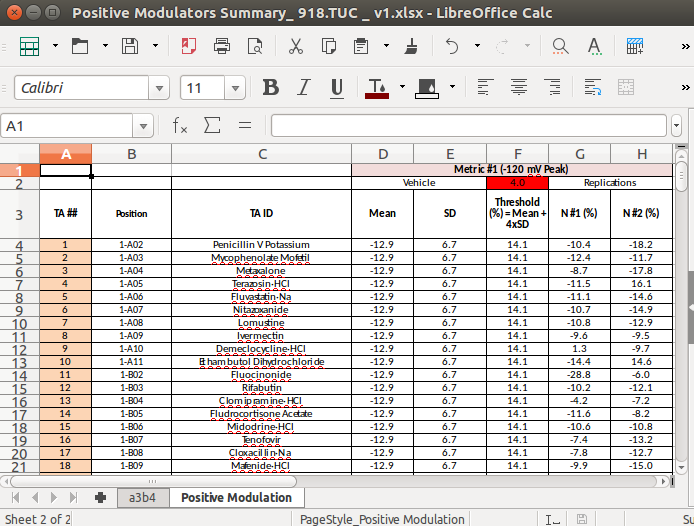

In [3]:
import os
from IPython.display import Image, display
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_screenshot = os.path.join(current_dir, 'assets/dataset_preparation_gui.png')
display(Image(filename=data_screenshot))

We see the data of interest is on the second sheet, and contained in columns "TA ID", "N #1 (%)", and "N #2 (%)".

Additionally, it appears much of this spreadsheet was formatted for human readability (multicolumn headers, column labels with spaces and symbols, etc.).  This makes the creation of a neat dataframe object harder.  For this reason we will cut everything that is unnecesary or inconvenient.



In [4]:
import deepchem as dc
dc.utils.download_url(
    'https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
    current_dir,
    'Positive Modulators Summary_ 918.TUC _ v1.xlsx'
)

In [6]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [7]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.868936,6.747049,14.119261,-10.40397,-18.192942
3,2,1-A03,Mycophenolate Mofetil,-12.868936,6.747049,14.119261,-12.445268,-11.717468
4,3,1-A04,Metaxalone,-12.868936,6.747049,14.119261,-8.655724,-17.775287


Note that the actual row headers are stored in row 1 and not 0 above.

In [8]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [9]:
# preview cleaner dataframe
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.40397,-18.192942
1,3,Mycophenolate Mofetil,-12.445268,-11.717468
2,4,Metaxalone,-8.655724,-17.775287
3,5,Terazosin·HCl,-11.504804,16.082458
4,6,Fluvastatin·Na,-11.135366,-14.553018


This formatting is closer to what we need.

Now, let's take the drug names and get smiles strings for them (format needed for DeepChem).

In [10]:
drugs = raw_data['drug'].values

For many of these, we can retreive the smiles string via the canonical_smiles attribute of the `get_compounds` object (using `pubchempy`)

In [11]:
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [12]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

However, some of these drug names have variables spaces and symbols (·, (±), etc.), and names that may not be readable by pubchempy. 

For this task, we will do a bit of hacking via regular expressions.  Also, we notice that all ions are written in a shortened form that will need to be expanded.  For this reason we use a dictionary, mapping the shortened ion names to versions recognizable to pubchempy.  

Unfortunately you may have several corner cases that will require more hacking.

In [13]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)
                   
    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

Now let's actually convert all these compounds to smiles. This conversion will take a few minutes so might not be a bad spot to go grab a coffee or tea and take a break while this is running! Note that this conversion will sometimes fail so we've added some error handling to catch these cases below.

In [14]:
smiles_map = {}
for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
    except:
        print("Errored on %s" % i)
        continue

Errored on 162


In [15]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [16]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018


Hooray, we have mapped each drug name to its corresponding smiles code.

Now, we need to look at the data and remove as much noise as possible.

## De-noising data

In machine learning, we know that there is no free lunch.  You will need to spend time analyzing and understanding your data in order to frame your problem and determine the appropriate model framework.  Treatment of your data will depend on the conclusions you gather from this process.

Questions to ask yourself:
* What are you trying to accomplish?
* What is your assay?
* What is the structure of the data?
* Does the data make sense?
* What has been tried previously?

For this project (respectively):
* I would like to build a model capable of predicting the affinity of an arbitrary small molecule drug to a particular ion channel protein
* For an input drug, data describing channel inhibition
* A few hundred drugs, with n=2
* Will need to look more closely at the dataset*
* Nothing on this particular protein

*This will involve plotting, so we will import matplotlib and seaborn.  We will also need to look at molecular structures, so we will import rdkit. We will also use the seaborn library which you can install with `conda install seaborn`.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

Our goal is to build a small molecule model, so let's make sure our molecules are all small.  This can be approximated by the length of each smiles string.

Text(0, 0.5, 'probability')

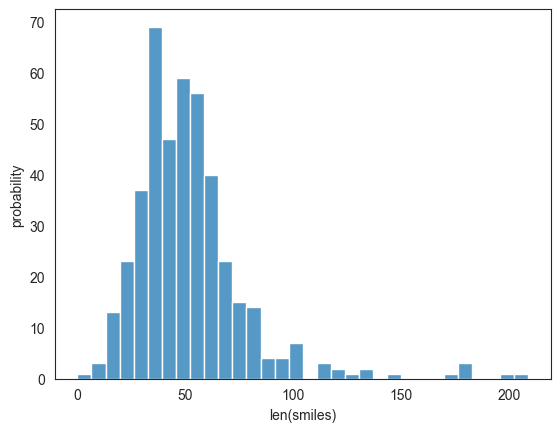

In [20]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

Some of these look rather large, len(smiles) > 150.  Let's see what they look like.

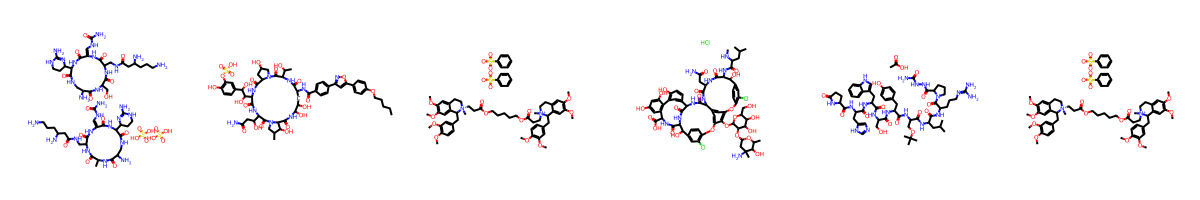

In [21]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

As suspected, these are not small molecules, so we will remove them from the dataset.  The argument here is that these molecules could register as inhibitors simply because they are large.  They are more likely to sterically blocks the channel, rather than diffuse inside and bind (which is what we are interested in).

The lesson here is to remove data that does not fit your use case.

In [22]:
# drop large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

Now, let's look at the numerical structure of the dataset.

First, check for NaNs.

In [23]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
62,NaN,-7.826604
162,-12.845569,-11.462743
175,NaN,-6.612245
187,NaN,-8.233257
233,-8.21781,NaN
262,NaN,-12.878803
288,NaN,-2.34264
300,NaN,-8.199364
301,NaN,-10.46326
311,NaN,-8.787216


I don't trust n=1, so I will throw these out.  

Then, let's examine the distribution of n1 and n2.

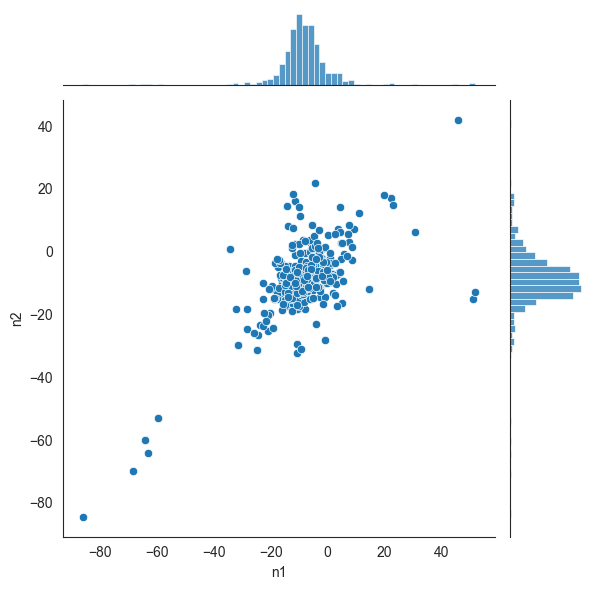

In [24]:
df = smiles_data.dropna(axis=0, how='any')
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data) 

We see that most of the data is contained in the gaussian-ish blob centered a bit below zero.  We see that there are a few clearly active datapoints located in the bottom left, and one on the top right.  These are all distinguished from the majority of the data.  How do we handle the data in the blob?  

Because n1 and n2 represent the same measurement, ideally they would be of the same value.  This plot should be tightly aligned to the diagonal, and the pearson correlation coefficient should be 1.  We see this is not the case.  This helps gives us an idea of the error of our assay.

Let's look at the error more closely, plotting in the distribution of (n1-n2).

Text(0, 0.5, 'probability')

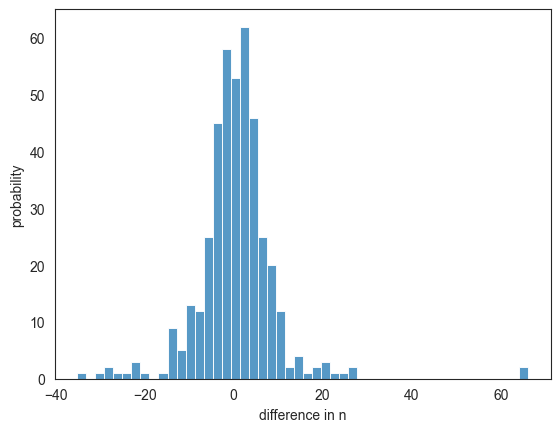

In [25]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

This looks pretty gaussian, let's get the 95% confidence interval by fitting a gaussian via scipy, and taking 2*the standard deviation

In [26]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.789073944091797

Now, I don't trust the data outside of the confidence interval, and will therefore drop these datapoints from df.  

For example, in the plot above, at least one datapoint has n1-n2 > 60.  This is disconcerting.

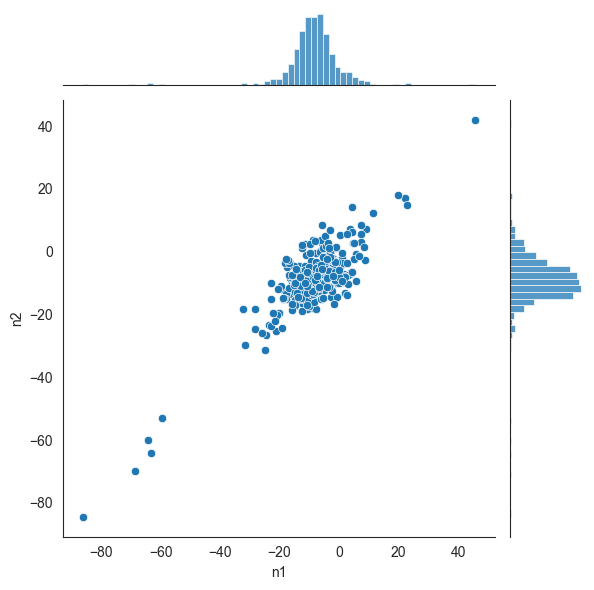

In [27]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df) 

Now that data looks much better!

So, let's average n1 and n2, and take the error bar to be ci_95.

In [28]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

Now, let's look at the sorted data with error bars.

Text(0, 0.5, 'activity')

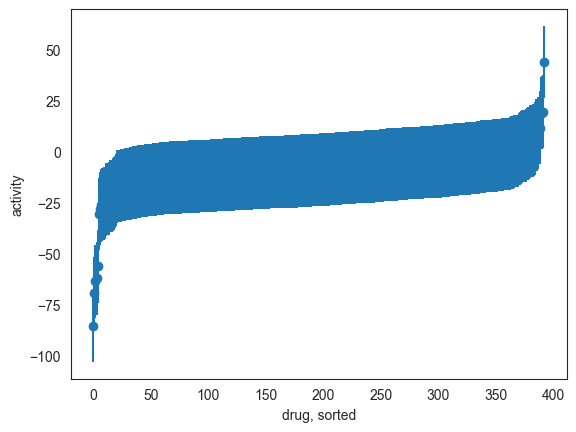

In [29]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

Now, let's identify our active compounds.  

In my case, this required domain knowledge.  Having worked in this area, and having consulted with professors specializing on this channel, I am interested in compounds where the absolute value of the activity is greater than 25.  This relates to the desired drug potency we would like to model.

If you are not certain how to draw the line between active and inactive, this cutoff could potentially be treated as a hyperparameter.

<ErrorbarContainer object of 3 artists>

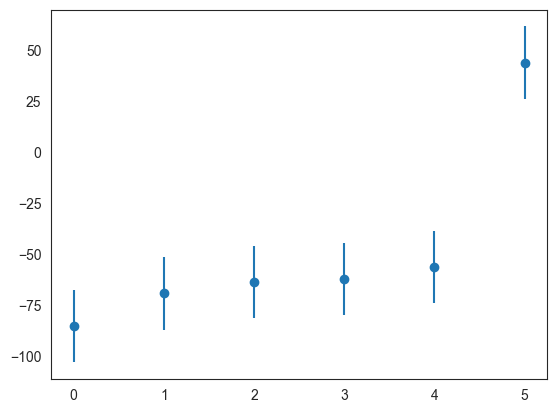

In [30]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [31]:
# summary
print (raw_data.shape, avg_df.shape, len(actives.index))

(430, 5) (393, 3) 6


In summary, we have:
* Removed data that did not address the question we hope to answer (small molecules only)
* Dropped NaNs
* Determined the noise of our measurements
* Removed exceptionally noisy datapoints
* Identified actives (using domain knowledge to determine a threshold)

## Determine model type, final form of dataset, and sanity load

Now, what model framework should we use?  

Given that we have 392 datapoints and 6 actives, this data will be used to build a low data one-shot classifier (10.1021/acscentsci.6b00367).  If there were datasets of similar character, transfer learning could potentially be used, but this is not the case at the moment.


Let's apply logic to our dataframe in order to cast it into a binary format, suitable for classification.

In [32]:
# 1 if condition for active is met, 0 otherwise
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

Now, save this to file.

In [33]:
avg_df.to_csv('modulators.csv', index=False)

Now, we will convert this dataframe to a DeepChem dataset.

In [34]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

Lastly, it is often advantageous to numerically transform the data in some way.  For example, sometimes it is useful to normalize the data, or to zero the mean.  This depends in the task at hand.

Built into DeepChem are many useful transformers, located in the deepchem.transformers.transformers base class. 

Because this is a classification model, and the number of actives is low, I will apply a balancing transformer.  I treated this transformer as a hyperparameter when I began training models.  It proved to unambiguously improve model performance.

In [35]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

Now let's save the balanced dataset object to disk, and then reload it as a sanity check.

In [36]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')

Tutorial written by Keri McKiernan (github.com/kmckiern) on September 8, 2016

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!


# Bibliography

[2] Anderson, Eric, Gilman D. Veith, and David Weininger. "SMILES, a line
notation and computerized interpreter for chemical structures." US
Environmental Protection Agency, Environmental Research Laboratory, 1987.